# Tarea 2 - MAN3160



**Profesor**: Denis Parra

**Ayudante**: Álvaro Labarca.


En esta tarea, utilizaremos la librería Implicit vista en los tutoriales del curso para comparar el rendimiento de los modelos ALS y BPR.
Para realizar la tarea, deberán leer y ejecutar todas las celdas del notebook y completar/responder las actividades que serán dadas.

In [14]:
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import implicit
import scipy.sparse as sparse
import time

In [3]:
train_dir = "ml-100k/u3.base"
test_dir = "ml-100k/u3.test"

In [4]:
import pandas as pd

train_file = pd.read_csv(train_dir, sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)
test_file = pd.read_csv(test_dir, sep='\t', names=['userid', 'itemid', 'rating', 'timestamp'], header=None)
display(train_file.head())
display(test_file.head())

,userid,itemid,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,6,5,887431973


,userid,itemid,rating,timestamp
0,1,5,3,889751712
1,1,11,2,875072262
2,1,16,5,878543541
3,1,25,4,875071805
4,1,35,1,878542420


In [5]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

pd.options.display.max_columns = None

info_file = pd.read_csv('ml-100k/u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')

info_file.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [6]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

In [7]:
def evaluate_model(model, n):
    mean_map = 0.
    mean_ndcg = 0.
    for u in user_items_test.keys():
        rec = model.recommend(user_ids[u], user_item_matrix[user_ids[u]], n)[0]
        rec = [itemset[r] for r in rec]
        rel_vector = [np.isin(rec, user_items_test[u], assume_unique=True).astype(int)]
        mean_map += mean_average_precision(rel_vector)
        mean_ndcg += ndcg_at_k(rel_vector, n)

    mean_map /= len(user_items_test)
    mean_ndcg /= len(user_items_test)

    return mean_map, mean_ndcg

In [8]:
def show_recommendations(model, user, n):
    recommendations = model.recommend(userid=user_ids[user], user_items=user_item_matrix[user_ids[user]], N=n)
    return df_items.loc[recommendations[0]]['title']

In [9]:
#Transformo las calificaciones, en el archivo de entrenamiento y test, para que sean implícitas de la siguiente manera:
# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
train_file.rating = [1 if x >=3 else 0 for x in train_file.rating]
test_file.rating = [1 if x >= 3 else 0 for x in test_file.rating ]

display(train_file.head())
display(test_file.head())

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,3,1,878542960
3,1,4,1,876893119
4,1,6,1,887431973


,userid,itemid,rating,timestamp
0,1,5,1,889751712
1,1,11,0,875072262
2,1,16,1,878543541
3,1,25,1,875071805
4,1,35,0,878542420


In [10]:
# Comprobar la cantidad de usuarios e items en los datos de entrenamiento y test

unique_user_ids_train = train_file['userid'].unique()
unique_item_ids_train = train_file['itemid'].unique()

print("Cantidad de valores únicos de usuarios en el conjunto de entrenamiento:", len(unique_user_ids_train))
print("Cantidad de valores únicos de items en el conjunto de entrenamiento:", len(unique_item_ids_train))

unique_user_ids_test = test_file['userid'].unique()
unique_item_ids_test = test_file['itemid'].unique()

print("Cantidad de valores únicos de usuarios en el conjunto de test:", len(unique_user_ids_test))
print("Cantidad de valores únicos de items en el conjunto de test:", len(unique_item_ids_test))

Cantidad de valores únicos de usuarios en el conjunto de entrenamiento: 943
Cantidad de valores únicos de items en el conjunto de entrenamiento: 1650
Cantidad de valores únicos de usuarios en el conjunto de test: 869
Cantidad de valores únicos de items en el conjunto de test: 1423


In [11]:
# Preprocesar los datos a formato sparse

# Inicializa un diccionario para almacenar los items que cada usuario ha interactuado
user_items = {}

# Inicializa un conjunto para almacenar todos los items únicos que aparecen en los datos
itemset = set()

# Recorre cada fila del dataframe 'df_train'
for row in train_file.itertuples():
    # Si el usuario (row[1]) no está en el diccionario user_items, añade el usuario con una lista vacía
    if row[1] not in user_items:
        user_items[row[1]] = []

    # Añade el item (row[2]) a la lista de items del usuario correspondiente
    user_items[row[1]].append(row[2])

    # Añade el item a itemset, asegurando que todos los items sean únicos
    itemset.add(row[2])

# Convierte itemset en un array numpy ordenado
itemset = np.sort(list(itemset))

# Crea una matriz de ceros con dimensiones [número de usuarios] x [número de items únicos]
sparse_matrix = np.zeros((len(user_items), len(itemset)))

# Recorre los items de cada usuario para crear una fila en la matriz
for i, items in enumerate(user_items.values()):
    # Marca con 1 los items que el usuario ha interactuado en la matriz dispersa
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)

# Convierte la matriz de numpy a una matriz CSR (Compressed Sparse Row) para optimizar almacenamiento y operaciones
user_item_matrix = sparse.csr_matrix(sparse_matrix)

# Crea un diccionario para mapear IDs de usuarios a índices de filas en la matriz
user_ids = {key: i for i, key in enumerate(user_items.keys())}

# Crea un diccionario para mapear IDs de items a índices de columnas en la matriz
items_ids = {key: i for i, key in enumerate(itemset)}

In [12]:
model1 = implicit.als.AlternatingLeastSquares(factors=5)
model1.fit(user_item_matrix)

/opt/homebrew/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 10 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

In [20]:
evaluate_model(model1, 5)

(0.5120958429561187, 0.7551963048498845)

## Descarga del dataset

Al igual que en la tarea 1 y los tutoriales del curso, vamos a descargar el dataset [MovieLens-100k](https://grouplens.org/).

Podemos descargar el dataset directamente con el comando wget.

In [134]:
!pip install wget
!pip install zipfile36
!pip3 install implicit --upgrade
!python3 -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
  9% [....                                                  ]  450560 / 4924029^C
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/homebrew/lib/python3.11/site-packages/wget.py", line 568, in <module>
    filename = download(args[0], out=options.output)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/wget.py", line 526, in download
    (tmpfile, headers) = ulib.urlretrieve(binurl, tmpfile, callback)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [135]:
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import implicit
import scipy.sparse as sparse
import time

In [137]:
train_dir = "ml-100k/u3.base"
test_dir = "ml-100k/u3.test"

In [138]:
import pandas as pd

train_file = pd.read_csv(train_dir, sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)

train_file.head()

,userid,itemid,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,6,5,887431973


In [139]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

pd.options.display.max_columns = None

info_file = pd.read_csv('ml-100k/u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')

info_file.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


## Funciones

In [140]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

In [141]:
def evaluate_model(model, n):
    mean_map = 0.
    mean_ndcg = 0.
    for u in user_items_test.keys():
        rec = model.recommend(user_ids[u], user_item_matrix[user_ids[u]], n)[0]
        rec = [itemset[r] for r in rec]
        rel_vector = [np.isin(rec, user_items_test[u], assume_unique=True).astype(int)]
        mean_map += mean_average_precision(rel_vector)
        mean_ndcg += ndcg_at_k(rel_vector, n)

    mean_map /= len(user_items_test)
    mean_ndcg /= len(user_items_test)

    return mean_map, mean_ndcg

In [142]:
def show_recommendations(model, user, n):
    recommendations = model.recommend(userid=user_ids[user], user_items=user_item_matrix[user_ids[user]], N=n)
    return df_items.loc[recommendations[0]]['title']

In [143]:
model1 = implicit.als.AlternatingLeastSquares(factors=5)
model1.fit(user_item_matrix)

  0%|          | 0/15 [00:00<?, ?it/s]

In [144]:
evaluate_model(model1, 5)

(0.4974547729022316, 0.7263279445727483)

# Actividades

### Actividad 1: Preparación del dataset

Prepare el dataset para que este pueda ser utilizado por los algoritmos de la librería Implicit. (Puede utilizar de base los tutoriales del curso), hasta generar la matriz user_items en formato csr. Puede importar/utilizar cualquier librería adicional que desée.

#### Respuesta:

Ingrese su respuesta en código a continuación. Puede utilizar todas las celdas de código que estime necesaria. Al finalizar, añada una celda de texto (Markdown en Jupyter) explicando qué contiene la matriz csr generada, qué representan sus columnas, sus filas y sus celdas internas.

In [106]:
# Primero, creamos la matriz user item sparse para los datos de entrenamiento
user_items = {}
itemset = set()

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
train_file.rating = [1 if x >= 3 else 0 for x in train_file.rating ]

# Iteramos sobre cada fila del dataframe de entrenamiento
for row in train_file.itertuples():
    if row[3]: # Si hay rating

        # Si el usuario no está en el diccionario, lo agregamos
        if row[1] not in user_items:
            user_items[row[1]] = []

        user_items[row[1]].append(row[2])
        itemset.add(row[2])

itemset = np.sort(list(itemset))

# Creamos la matriz csr user-item
sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)

user_item_matrix = sparse.csr_matrix(sparse_matrix)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
items_ids = {key: i for i, key in enumerate(itemset)}

In [17]:
# Ahora, creamos el dataframe de test desde los datos
df_test = pd.read_csv(test_dir,
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

df_test.head()

,userid,itemid,rating,timestamp
0,1,5,3,889751712
1,1,11,2,875072262
2,1,16,5,878543541
3,1,25,4,875071805
4,1,35,1,878542420


In [18]:
# Creamos la matriz de usuario-item para el test set

# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0)
df_test.rating = [1 if x >= 3 else 0 for x in df_test.rating]

user_items_test = {}
itemset_test = set()

# Creamos un diccionario con los items de test para cada usuario
for row in df_test.itertuples():
    if row[3]:
        if row[1] not in user_items_test:
            user_items_test[row[1]] = []

        user_items_test[row[1]].append(row[2])
        itemset_test.add(row[2])

itemset_test = np.sort(list(itemset_test))

# Creamos la matriz csr user-item para los datos de test
sparse_matrix_test = np.zeros((len(user_items_test), len(itemset_test)))

for i, items in enumerate(user_items_test.values()):
    sparse_matrix_test[i] = np.isin(itemset_test, items, assume_unique=True).astype(int)

user_item_matrix_test = sparse.csr_matrix(sparse_matrix_test)

In [19]:
user_item_matrix_test.shape

(866, 1301)

In [111]:
# Finalmente, creamos una copia del dataframe de items para cumplir con el nombre de la función show_recommendations
df_items = info_file.copy()
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [112]:
user_item_matrix.shape

(943, 1538)

#### Vamos a explicar la matriz CSR calculada.

La matriz es de dimensiones (M usuarios) x (N ítems), es decir, cada fila `i` representa un usuario `i+1` y cada columna `j` representa la interacción del usuario con cada ítem (película) `j+1` disponible en el dataset de película. En este caso, disponemos de `943` usuarios y de `1538` películas. Es importante mencionar que si el usuario tuvo interacción con el ítem, es decir, si rankeó una película, esto se denota como 1 y, en caso que el usuario no haya rankeado la película, se denota como 0. Lo anterior se obtuvo transformando los datos desde feedback explícito a feedback implícito bajo el código `[1 if x >= 3 else 0 for x in train_file.rating]`. En otro caso, el problema se puede abordar en torno al rating, siendo un valor entre 1 y 5, o 0 en caso de no haber interactuado con la película.

### Actividad 2: Entrenamiento de modelo ALS

Entrene el modelo bpr con el set de entrenamiento y realice un estudio de hiperparámetros sobre al menos 2 hiperparámetros del modelo. Despliegue el gráfico sobre la variación del rendimiento (en base a las métricas nDCG y MAP) según el valor del hiperparámetro y explique explícitamente la forma de los gráficos, las conclusiones obtenidas de ellos y la mejor combinación de hiperparámetros en su opinión. Registre y haga un gráfico del tiempo de entrenamiento de cada método. Se recomienda usar la librería _time_ para esto.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

In [113]:
# Utilizamos los siguientes hiperparámetros para el entrenamiento de ALS:
# Factores latentes
# Factor de regularización

factores_als = [i*5 for i in range(1, 11)]
reg_fac_als = [5e-2 + i*1e-4*50 for i in range(11)]

In [114]:
# Creamos un decorador para calcular el tiempo de ejecución al entrenar un modelo
import time

def timer(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"Tiempo de ejecución (s): {end-start}")
        return result, end-start
    return wrapper

In [115]:
# Creamos una función para entrenar un modelo y le aplicamos el decorador de tiempo
@timer
def train_model(model):
    model.fit(user_item_matrix)
    return model

In [116]:
# Entrenamos bajo los hiperparámetros definidos y evaluamos sobre una lista de recomendaciones de largo 10
n = 10

map_f_als = []
ndcg_f_als = []

map_rg_als = []
ndcg_rg_als = []

train_times_f_als = []
train_times_rg_als = []

for f in factores_als:
    print('Training model with', f, 'latent factors')
    model_als = implicit.als.AlternatingLeastSquares(factors=f)
    model_als, train_time_f = train_model(model_als)
    mmap, ndcg = evaluate_model(model_als, n)
    map_f_als.append(mmap)
    ndcg_f_als.append(ndcg)
    train_times_f_als.append(train_time_f)
    print('')
    
for rg in reg_fac_als:
    print('Training model with', rg, 'regularization factor')
    model_als = implicit.als.AlternatingLeastSquares(regularization=rg)
    model_als, train_time_rg = train_model(model_als)
    mmap, ndcg = evaluate_model(model_als, n)
    map_rg_als.append(mmap)
    ndcg_rg_als.append(ndcg)
    train_times_rg_als.append(train_time_rg)
    print()

Training model with 5 latent factors


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 0.3573269844055176

Training model with 10 latent factors


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 0.39553403854370117

Training model with 15 latent factors


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 0.6475381851196289

Training model with 20 latent factors


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 0.6272420883178711

Training model with 25 latent factors


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 0.7588279247283936

Training model with 30 latent factors


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 0.7401220798492432

Training model with 35 latent factors


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 0.8559281826019287

Training model with 40 latent factors


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 0.809049129486084

Training model with 45 latent factors


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 1.5276179313659668

Training model with 50 latent factors


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 2.4525022506713867

Training model with 0.05 regularization factor


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 2.00308895111084

Training model with 0.055 regularization factor


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 2.4427239894866943

Training model with 0.060000000000000005 regularization factor


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 2.1539041996002197

Training model with 0.065 regularization factor


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 2.2077691555023193

Training model with 0.07 regularization factor


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 2.9652259349823

Training model with 0.07500000000000001 regularization factor


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 2.1631968021392822

Training model with 0.08 regularization factor


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 2.3694777488708496

Training model with 0.08499999999999999 regularization factor


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 1.9883460998535156

Training model with 0.09 regularization factor


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 2.475269079208374

Training model with 0.095 regularization factor


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 2.23795485496521

Training model with 0.1 regularization factor


  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 2.7034647464752197



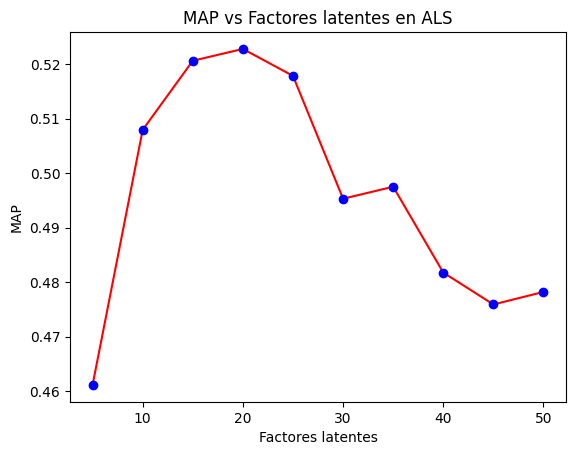

In [117]:
# Graficamos los resultados según los factores latentes para MAP
plt.plot(factores_als, map_f_als, 'r-')
plt.plot(factores_als, map_f_als, 'bo')
plt.xlabel('Factores latentes')
plt.ylabel('MAP')
plt.title('MAP vs Factores latentes en ALS')
plt.show()


In [118]:
factores_als[2]

15

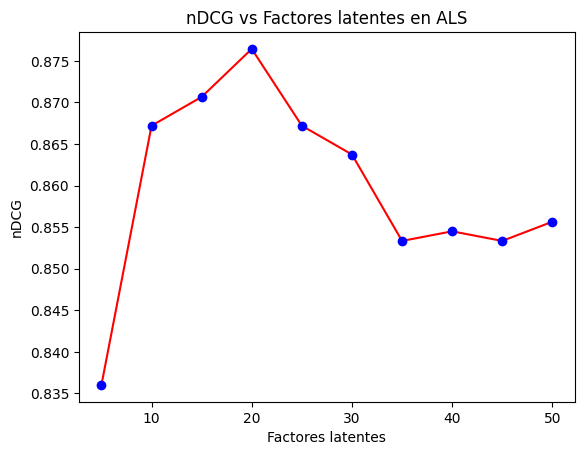

In [119]:
# Graficamos los resultados según los factores latentes para NDCG
plt.plot(factores_als, ndcg_f_als, 'r-')
plt.plot(factores_als, ndcg_f_als, 'bo')
plt.xlabel('Factores latentes')
plt.ylabel('nDCG')
plt.title('nDCG vs Factores latentes en ALS')
plt.show()

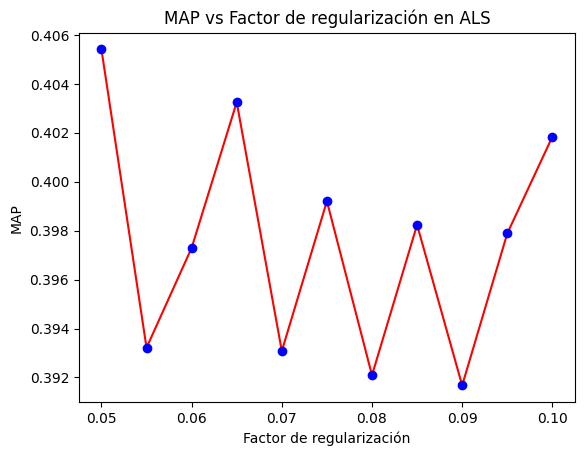

In [120]:
# Ahora, graficamos los resultados según el factor de regularización para MAP
plt.plot(reg_fac_als, map_rg_als, 'r-')
plt.plot(reg_fac_als, map_rg_als, 'bo')
plt.xlabel('Factor de regularización')
plt.ylabel('MAP')
plt.title('MAP vs Factor de regularización en ALS')
plt.show()

In [121]:
reg_fac_als[6]

0.08

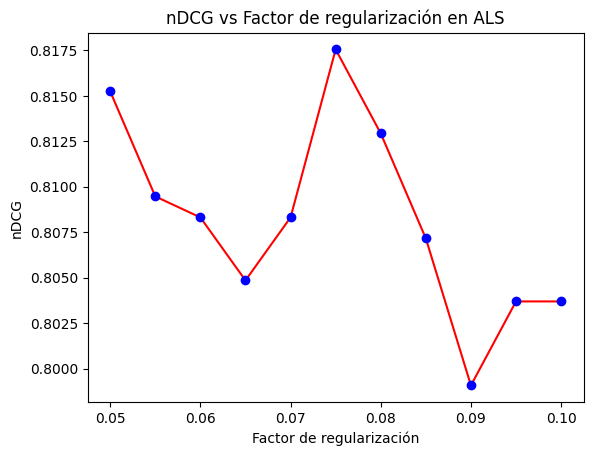

In [122]:
# Graficamos los resultados según el factor de regularización para NDCG
plt.plot(reg_fac_als, ndcg_rg_als, 'r-')
plt.plot(reg_fac_als, ndcg_rg_als, 'bo')
plt.xlabel('Factor de regularización')
plt.ylabel('nDCG')
plt.title('nDCG vs Factor de regularización en ALS')
plt.show()


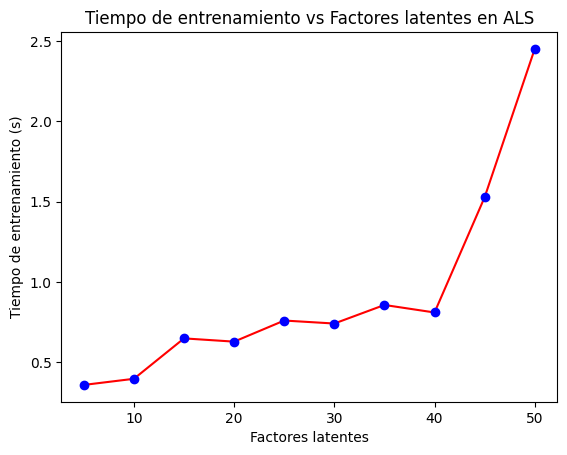

In [123]:
# Ahora, graficamos los tiempos de entrenamiento para los factores latentes
plt.plot(factores_als, train_times_f_als, 'r-')
plt.plot(factores_als, train_times_f_als, 'bo')
plt.xlabel('Factores latentes')
plt.ylabel('Tiempo de entrenamiento (s)')
plt.title('Tiempo de entrenamiento vs Factores latentes en ALS')
plt.show()

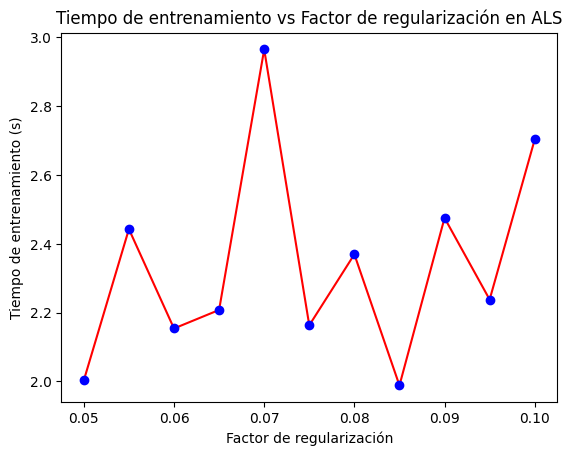

In [124]:
# Por último, graficamos los tiempos de entrenamiento para el factor de regularización
plt.plot(reg_fac_als, train_times_rg_als, 'r-')
plt.plot(reg_fac_als, train_times_rg_als, 'bo')
plt.xlabel('Factor de regularización')
plt.ylabel('Tiempo de entrenamiento (s)')
plt.title('Tiempo de entrenamiento vs Factor de regularización en ALS')
plt.show()

### Factores latentes:

Podemos ver que el número óptimo de factores latentes que maximizan el MAP y el nDCG está dado por entre `20 factores` y `25 factores` latentes, ya que tanto para MAP como nDCG se puede ver claramente en esa cantidad de factores, manteniendo todo lo demás constante, el valor de las métricas es el mayor y por ende el ránking predicho tiene mejor desempeño. Sin embargo, en el caso de la métrica `MAP`, si aumentamos de 20 la cantidad de factores, esta métrica decae, por lo que dejamos la cantidad óptima de factores como `factores_latentes = 20`. Por otra parte, vemos que el tiempo de entrenamiento tiende a ser creciente según el aumento de factores, lo cual puede tener sentido ya que va estrechamente relacionado a la cantidad de operaciones matriciales, que aumentan el tiempo. De todas manera, el tiempo de proceso para 20 factores sigue dentro de lo bajo, pero podemos ver que ya sobre 45 factores latentes, el tiempo se comienza a disparar.

### Factor de regularización

Con respecto al factor de regularización, vemos que el óptimo se encuentra en `0.08`. Esto, dado que maximiza en este punto tanto a `MAP` como a `nDCG`. De cualquier forma, en este factor no se permite apreciar una tendencia tan clara sobre aquel número, dado que simplemente es un factor que nos permite ir penalizando valores muy altos de los vectores latentes, lo que es un proceso iterativo, lo que explica los altos y bajos de la curva. Por otra parte, podemos ver que el tiempo de entrenamiento no es el más alto con el factor en `0.08`. De hecho incluso se ve un mínimo local, lo que no es un factor preponderante para no considerar este valor de hiperparámetro como óptimo.




### Actividad 3: Entrenamiento de modelo BPR

Repita el procedimiento de la Actividad 2 para el modelo BPR. Recuerde realizar un estudio de hiperparámetros sobre dos hiperparámetros distintos y exponer sus observaciones, elecciones como mejor combinación de hiperparámetros y realizar un análisis del tiempo de entrenamiento.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

In [125]:
# Repetimos el mismo proceso pero para BPR
# Utilizamos el mismo hiperparámetro de factores latentes para el entrenamiento de BPR pero ahora consideramos iteraciones
# Factores latentes
# Factor de regularización

factores_bpr = [i*5 for i in range(1, 11)]
it_bpr = [i*10 for i in range(1, 11)]

In [126]:
# Entrenamos bajo los hiperparámetros definidos y evaluamos sobre una lista de recomendaciones de largo 10
n = 10

map_f_bpr = []
ndcg_f_bpr = []

map_it_bpr = []
ndcg_it_bpr = []

train_times_f_bpr = []
train_times_it_bpr = []

for f in factores_bpr:
    print('Training model with', f, 'latent factors')
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f)
    model_bpr, train_time_f = train_model(model_bpr)
    mmap, ndcg = evaluate_model(model_bpr, n)
    map_f_bpr.append(mmap)
    ndcg_f_bpr.append(ndcg)
    train_times_f_bpr.append(train_time_f)
    print('')
    
for it in it_bpr:
    print('Training model with', it, 'regularization factor')
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(iterations=it)
    model_bpr, train_time_rg = train_model(model_bpr)
    mmap, ndcg = evaluate_model(model_bpr, n)
    map_it_bpr.append(mmap)
    ndcg_it_bpr.append(ndcg)
    train_times_it_bpr.append(train_time_rg)
    print()

Training model with 5 latent factors


  0%|          | 0/100 [00:00<?, ?it/s]

Tiempo de ejecución (s): 0.8265700340270996

Training model with 10 latent factors


  0%|          | 0/100 [00:00<?, ?it/s]

Tiempo de ejecución (s): 0.9848151206970215

Training model with 15 latent factors


  0%|          | 0/100 [00:00<?, ?it/s]

Tiempo de ejecución (s): 1.0174641609191895

Training model with 20 latent factors


  0%|          | 0/100 [00:00<?, ?it/s]

Tiempo de ejecución (s): 0.9970319271087646

Training model with 25 latent factors


  0%|          | 0/100 [00:00<?, ?it/s]

Tiempo de ejecución (s): 0.9936282634735107

Training model with 30 latent factors


  0%|          | 0/100 [00:00<?, ?it/s]

Tiempo de ejecución (s): 1.0455920696258545

Training model with 35 latent factors


  0%|          | 0/100 [00:00<?, ?it/s]

Tiempo de ejecución (s): 1.166933298110962

Training model with 40 latent factors


  0%|          | 0/100 [00:00<?, ?it/s]

Tiempo de ejecución (s): 1.151684045791626

Training model with 45 latent factors


  0%|          | 0/100 [00:00<?, ?it/s]

Tiempo de ejecución (s): 1.3138477802276611

Training model with 50 latent factors


  0%|          | 0/100 [00:00<?, ?it/s]

Tiempo de ejecución (s): 1.4374721050262451

Training model with 10 regularization factor


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

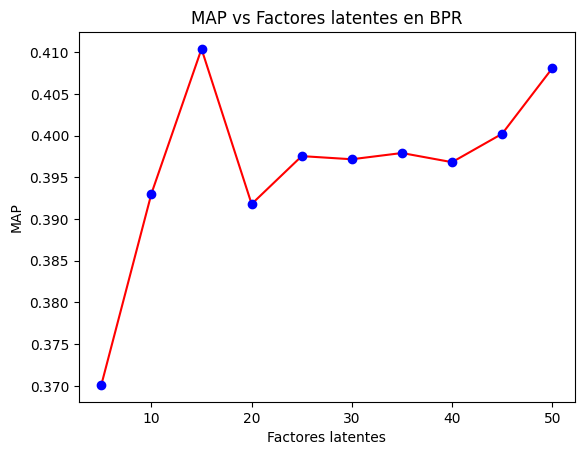

In [ ]:
# Graficamos MAP vs Factores latentes en BPR
plt.plot(factores_bpr, map_f_bpr, 'r-')
plt.plot(factores_bpr, map_f_bpr, 'bo')
plt.xlabel('Factores latentes')
plt.ylabel('MAP')
plt.title('MAP vs Factores latentes en BPR')
plt.show()


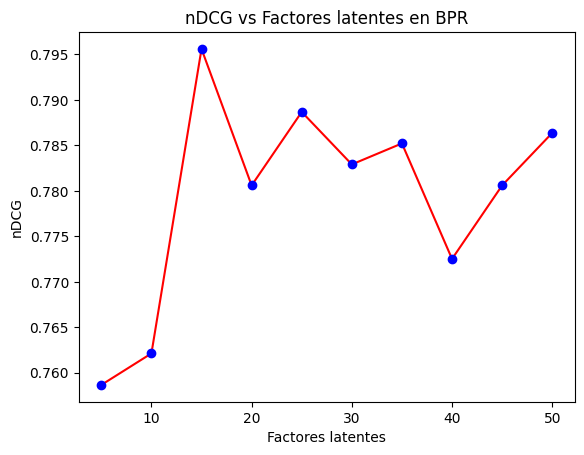

In [ ]:
# Repetimos el proceso, pero para nDCG
plt.plot(factores_bpr, ndcg_f_bpr, 'r-')
plt.plot(factores_bpr, ndcg_f_bpr, 'bo')
plt.xlabel('Factores latentes')
plt.ylabel('nDCG')
plt.title('nDCG vs Factores latentes en BPR')
plt.show()

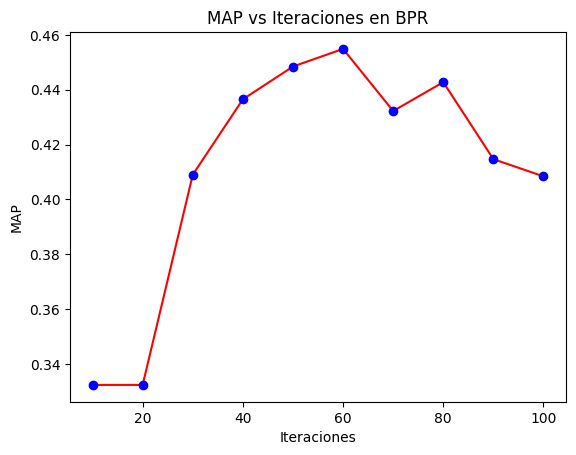

In [ ]:
# Graficamos MAP vs Iteraciones en BPR
plt.plot(it_bpr, map_it_bpr, 'r-')
plt.plot(it_bpr, map_it_bpr, 'bo')
plt.xlabel('Iteraciones')
plt.ylabel('MAP')
plt.title('MAP vs Iteraciones en BPR')
plt.show()

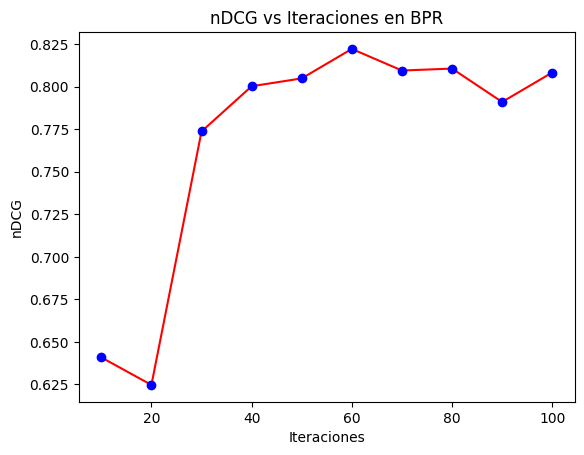

In [ ]:
# Graficamos nDCG vs Iteraciones en BPR
plt.plot(it_bpr, ndcg_it_bpr, 'r-')
plt.plot(it_bpr, ndcg_it_bpr, 'bo')
plt.xlabel('Iteraciones')
plt.ylabel('nDCG')
plt.title('nDCG vs Iteraciones en BPR')
plt.show()

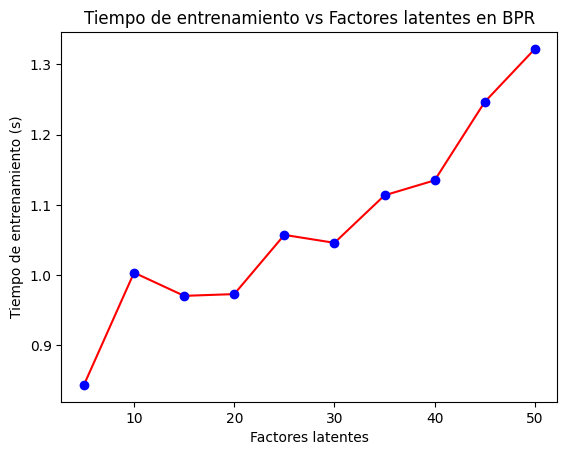

In [ ]:
# Graficamos los tiempos de entrenamiento para los factores latentes en BPR
plt.plot(factores_bpr, train_times_f_bpr, 'r-')
plt.plot(factores_bpr, train_times_f_bpr, 'bo')
plt.xlabel('Factores latentes')
plt.ylabel('Tiempo de entrenamiento (s)')
plt.title('Tiempo de entrenamiento vs Factores latentes en BPR')
plt.show()

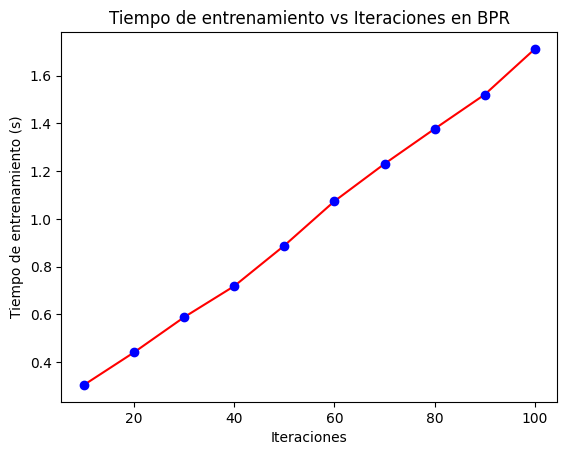

In [ ]:
# Graficamos los tiempos de entrenamiento para las iteraciones en BPR
plt.plot(it_bpr, train_times_it_bpr, 'r-')
plt.plot(it_bpr, train_times_it_bpr, 'bo')
plt.xlabel('Iteraciones')
plt.ylabel('Tiempo de entrenamiento (s)')
plt.title('Tiempo de entrenamiento vs Iteraciones en BPR')
plt.show()

### Factores latentes:

Podemos ver que el número óptimo de factores latentes que maximizan el MAP y el nDCG está dado por `15 factores` latentes, ya que tanto en MAP como nDCG, manteniendo todo lo demás constante, el valor de las métricas es el mayor y por ende el ránking predicho tiene mejor desempeño. Al mismo tiempo, similar al caso anterior, vemos que si aumentamos la cantidad de factores en más de 15, la métrica `MAP` comienza a decaer, posiblemente por caer en overfitting, por lo que dejamos la cantidad óptima de factores como `factores_latentes = 15`. Por otra parte, similar al caso con `ALS` vemos que el tiempo de entrenamiento tiende a ser creciente según el aumento de factores, lo cual puede tener sentido ya que va estrechamente relacionado a la cantidad de operaciones matriciales, que aumentan el tiempo.

### Número de iteraciones

Con respecto al número de iteraciones, vemos que el óptimo se encuentra en `60`. Luego de este número, la métrica tiende a estabilizarse en torno a este, aunque comienza a oscilar. Lo anterior nos puede indicar que se comienza a sobre generalizar sobre los datos y comienza el sobreajuste del modelo. Con 60 iteraciones, se puede ver que se maximiza tanto `MAP` como `nDCG`. Por otra parte, con respecto al tiempo, se puede ver que es prácticamente lineal con respecto a la cantidad de iteraciones. Eso, ya que el computador se toma un cierto tiempo en iterar una vez y por lo tanto si la iteración se repite `n` veces, al computador se demorará `n` por el tiempo de una iteración, lo que se refleja en la curva de iteraciones vs tiempo de procesamiento.



### Actividad 4: Comparación de modelos.

Entrene modelos ALS y BPR con la combinación de hiperparámetros seleccionadas de las actividades 2 y 3. Genere una tabla exponiendo los resultados de ambos modelos al evaluarlos según nDCG@k y MAP@k proporcionadas (son libres de elegir el valor de k). Incluya también el valor del tiempo de entrenamiento empleado.

Además, implemente y agregue a su tabla los resultados usando una métrica adicional estudiada en el curso. Esta métrica puede ser programada por ustedes o usando una función de una librería externa.

Finalmente comente sobre los resultados de la tabla y concluya qué método entregó los mejores resultados para el set de datos utilizado.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

In [ ]:
# Fijamos los valores óptimos de ALS y BPR encontrados anteriormente e instranciamos los modelos
f_opt_als = 20
rg_opt_als = 0.08
f_opt_bpr = 15
it_opt_bpr = 60

opt_als = implicit.als.AlternatingLeastSquares(factors=f_opt_als, regularization=rg_opt_als)
opt_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f_opt_bpr, iterations=it_opt_bpr)

In [ ]:
# Entrenamos los modelos con los valores óptimos
opt_als, train_time_als = train_model(opt_als)
opt_bpr, train_time_bpr = train_model(opt_bpr)

  0%|          | 0/15 [00:00<?, ?it/s]

Tiempo de ejecución (s): 0.42127394676208496


  0%|          | 0/60 [00:00<?, ?it/s]

Tiempo de ejecución (s): 0.5348861217498779


In [ ]:
# Evaluamos ambos modelos con k = 5
k = 5
mmap_als, ndcg_als = evaluate_model(opt_als, k)
mmap_bpr, ndcg_bpr = evaluate_model(opt_bpr, k)

In [133]:
# Implementar la métrica AUC para evaluar los recomendadores


import implicit.evaluation


def get_AUC_at_k(model, k):
    
    auc = implicit.evaluation.AUC_at_k(model,
                                       user_item_matrix,
                                       user_item_matrix_test,
                                       show_progress=False,
                                       K=k
                                    )
    return auc

# Evaluamos ambos modelos con k = 5
k = 10
auc_als = get_AUC_at_k(opt_als, k)
auc_bpr = get_AUC_at_k(opt_bpr, k)

print('AUC para ALS:', auc_als)
print('AUC para BPR:', auc_bpr)


AUC para ALS: 0.5066091736863211
AUC para BPR: 0.5018661177862237


In [88]:
# Definimos una tabla con los resultados obtenidos de los modelos
results = pd.DataFrame({'Modelo': ['ALS', 'BPR'],
                        'MAP': [mmap_als, mmap_bpr],
                        'nDCG': [ndcg_als, ndcg_bpr],
                        'k': [k, k],
                        'Tiempo de entrenamiento (s)': [train_time_als, train_time_bpr]})
results

,Modelo,MAP,nDCG,k,Tiempo de entrenamiento (s)
0,ALS,0.553663,0.795612,5,0.421274
1,BPR,0.419562,0.637413,5,0.534886


### Actividad 5: Comparación de modelos con modelo de feedback explícito.

Programe y evalúe un método de filtrado colaborativo de su elección sobre el mismo dataset. Evalúe este sistema y compare su rendimiento con los métodos de ALS y BPR entrenados en actividades anteriores. Recuerde que no todas las métricas son aplicables a sistemas de feedback explícito e implícito, por esto, seleccione al menos una métrica que permita realizar esta comparación. Justifique sus elecciones y concluya en base a los resultados dados.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

In [21]:
implicit.__version__

'0.7.2'